In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
from utils.pddataframes import (
    print_ocurrencies, plot_barchar, plot_multiple_barchar, get_high_season, get_period_day,
    plot_grouped_barchar
)
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix,  precision_recall_fscore_support

synthetic_features_csv = pd.read_csv("synthetic_features.csv")

columns_names = list(synthetic_features_csv)
synthetic_features_csv.head()

C:\Users\Felipe\AppData\Local\Temp/ipykernel_29900/3720199085.py:14: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  synthetic_features_csv = pd.read_csv("synthetic_features.csv")


,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1,-2.0,0,night


In [2]:
#Remove useless columns
from sklearn.preprocessing import OneHotEncoder
training_dataset = synthetic_features_csv.drop(['Fecha-O', 'Vlo-O', 'Des-O', 'Emp-O', 'min_diff', 'OPERA', 'Vlo-I'], axis = 1)
training_dataset = training_dataset.assign(fechats = lambda df: pd.to_datetime(
    df['Fecha-I'], format='%Y-%m-%d %H:%M:%S').astype(np.int64) // 10**9)
training_dataset = training_dataset.drop(['Fecha-I'], axis = 1)
training_dataset.head()
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Des-I        68205 non-null  object
 1   Emp-I        68205 non-null  object
 2   DIA          68205 non-null  int64 
 3   MES          68205 non-null  int64 
 4   DIANOM       68205 non-null  object
 5   TIPOVUELO    68205 non-null  object
 6   SIGLADES     68205 non-null  object
 7   high_season  68205 non-null  int64 
 8   delay_15     68205 non-null  int64 
 9   period_day   68205 non-null  object
 10  fechats      68205 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 5.7+ MB


In [3]:
training_dataset = training_dataset[['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'SIGLADES', 'period_day', 'DIA', 'MES', 'high_season', 'fechats', 'delay_15']]

training_dataset_columns = list(training_dataset)
print(training_dataset_columns)
training_dataset.head()

encoded_data = pd.get_dummies(training_dataset, columns = ['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'SIGLADES', 'period_day'])
encoded_data_headers = list(encoded_data)
print(encoded_data_headers)
encoded_data.head()


['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'SIGLADES', 'period_day', 'DIA', 'MES', 'high_season', 'fechats', 'delay_15']
['DIA', 'MES', 'high_season', 'fechats', 'delay_15', 'Des-I_CYYZ', 'Des-I_EGLL', 'Des-I_EGYP', 'Des-I_KATL', 'Des-I_KDFW', 'Des-I_KIAH', 'Des-I_KJFK', 'Des-I_KLAX', 'Des-I_KMCO', 'Des-I_KMIA', 'Des-I_LEMD', 'Des-I_LFPG', 'Des-I_LIRF', 'Des-I_MDPC', 'Des-I_MMMX', 'Des-I_MMUN', 'Des-I_MPTO', 'Des-I_NZAA', 'Des-I_SAAR', 'Des-I_SABE', 'Des-I_SACO', 'Des-I_SAEZ', 'Des-I_SAME', 'Des-I_SANT', 'Des-I_SANU', 'Des-I_SARI', 'Des-I_SAWH', 'Des-I_SAZN', 'Des-I_SAZS', 'Des-I_SBCT', 'Des-I_SBFI', 'Des-I_SBFL', 'Des-I_SBGL', 'Des-I_SBGR', 'Des-I_SCAR', 'Des-I_SCAT', 'Des-I_SCBA', 'Des-I_SCCF', 'Des-I_SCCI', 'Des-I_SCDA', 'Des-I_SCFA', 'Des-I_SCIE', 'Des-I_SCIP', 'Des-I_SCJO', 'Des-I_SCNT', 'Des-I_SCPQ', 'Des-I_SCQP', 'Des-I_SCSE', 'Des-I_SCTE', 'Des-I_SCVD', 'Des-I_SEGU', 'Des-I_SEQM', 'Des-I_SEQU', 'Des-I_SGAS', 'Des-I_SKBO', 'Des-I_SLCB', 'Des-I_SLLP', 'Des-I_SLVR', 'Des-I_SPJC', '

,DIA,MES,high_season,fechats,delay_15,Des-I_CYYZ,Des-I_EGLL,Des-I_EGYP,Des-I_KATL,Des-I_KDFW,...,SIGLADES_Sydney,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,period_day_afternoon,period_day_morning,period_day_night
0,1,1,1,1483313400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,1483399800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,1,1483486200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,1483572600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1,1,1483659000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
train, test = train_test_split(encoded_data, test_size=.3, random_state=1999)
train_X = train.drop(['delay_15'], axis = 1)
train_y = train[['delay_15']].astype('int')
test_X = test.drop(['delay_15'], axis = 1)
test_y = test[['delay_15']].astype('int')




In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X, train_y)
predictions = clf.predict(test_X)
accuracy_score(test_y, predictions)

0.7487537875085525

In [1]:
parameters = {'booster':['gbtree'], 'max_depth': [1,4,7],
     'eta':[0.2], 'objective': ['binary:logistic'],
     'num_parallel_tree': [1], 'n_jobs': [-1], 'tree_method': ['hist'],
     'n_estimators': [10], 'max_delta_step': [3], 'gamma': [0.]
              
    }
             

model = xgb.XGBClassifier()

clf = GridSearchCV(model, parameters, scoring='f1',  verbose=1000)
clf.fit(train_X, train_y)

NameError: name 'xgb' is not defined

In [7]:
predictions = clf.predict(test_X)
accuracy_score(test_y, predictions)

0.8123350601114261

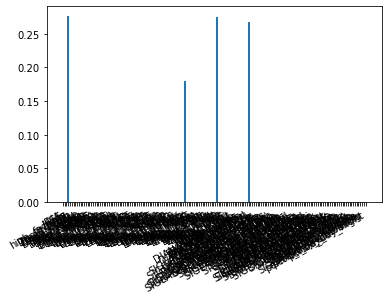

[0.         0.         0.         0.27693015 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17928578 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.27566838 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [8]:
fig, ax1 = plt.subplots()
feature_enc_headers = encoded_data_headers
#feature_enc_headers = feature_enc_headers.remove("delay_15")
ax1.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_, tick_label=list(train_X), width=1)
fig.autofmt_xdate()
plt.show()
print(clf.best_estimator_.feature_importances_)

importance_values = dict(zip(list(train_X), clf.best_estimator_.feature_importances_))
print(importance_values)


In [9]:
print(list(filter(lambda x: x[1] > 0, list(importance_values.items()))))
print(importance_values.items())

[('fechats', 0.27693015), ('Emp-I_ACA', 0.17928578), ('Emp-I_LAW', 0.27566838), ('TIPOVUELO_I', 0.2681157)]
dict_items([('DIA', 0.0), ('MES', 0.0), ('high_season', 0.0), ('fechats', 0.27693015), ('Des-I_CYYZ', 0.0), ('Des-I_EGLL', 0.0), ('Des-I_EGYP', 0.0), ('Des-I_KATL', 0.0), ('Des-I_KDFW', 0.0), ('Des-I_KIAH', 0.0), ('Des-I_KJFK', 0.0), ('Des-I_KLAX', 0.0), ('Des-I_KMCO', 0.0), ('Des-I_KMIA', 0.0), ('Des-I_LEMD', 0.0), ('Des-I_LFPG', 0.0), ('Des-I_LIRF', 0.0), ('Des-I_MDPC', 0.0), ('Des-I_MMMX', 0.0), ('Des-I_MMUN', 0.0), ('Des-I_MPTO', 0.0), ('Des-I_NZAA', 0.0), ('Des-I_SAAR', 0.0), ('Des-I_SABE', 0.0), ('Des-I_SACO', 0.0), ('Des-I_SAEZ', 0.0), ('Des-I_SAME', 0.0), ('Des-I_SANT', 0.0), ('Des-I_SANU', 0.0), ('Des-I_SARI', 0.0), ('Des-I_SAWH', 0.0), ('Des-I_SAZN', 0.0), ('Des-I_SAZS', 0.0), ('Des-I_SBCT', 0.0), ('Des-I_SBFI', 0.0), ('Des-I_SBFL', 0.0), ('Des-I_SBGL', 0.0), ('Des-I_SBGR', 0.0), ('Des-I_SCAR', 0.0), ('Des-I_SCAT', 0.0), ('Des-I_SCBA', 0.0), ('Des-I_SCCF', 0.0), ('Des-I

In [10]:
training_dataset = training_dataset[['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day', 'DIA', 'MES', 'high_season', 'fechats', 'delay_15']]

training_dataset_columns = list(training_dataset)
print(training_dataset_columns)
training_dataset.head()

encoded_data = pd.get_dummies(training_dataset, columns = ['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day'])
encoded_data_headers = list(encoded_data)
print(encoded_data_headers)
encoded_data.head()

['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day', 'DIA', 'MES', 'high_season', 'fechats', 'delay_15']
['DIA', 'MES', 'high_season', 'fechats', 'delay_15', 'Des-I_CYYZ', 'Des-I_EGLL', 'Des-I_EGYP', 'Des-I_KATL', 'Des-I_KDFW', 'Des-I_KIAH', 'Des-I_KJFK', 'Des-I_KLAX', 'Des-I_KMCO', 'Des-I_KMIA', 'Des-I_LEMD', 'Des-I_LFPG', 'Des-I_LIRF', 'Des-I_MDPC', 'Des-I_MMMX', 'Des-I_MMUN', 'Des-I_MPTO', 'Des-I_NZAA', 'Des-I_SAAR', 'Des-I_SABE', 'Des-I_SACO', 'Des-I_SAEZ', 'Des-I_SAME', 'Des-I_SANT', 'Des-I_SANU', 'Des-I_SARI', 'Des-I_SAWH', 'Des-I_SAZN', 'Des-I_SAZS', 'Des-I_SBCT', 'Des-I_SBFI', 'Des-I_SBFL', 'Des-I_SBGL', 'Des-I_SBGR', 'Des-I_SCAR', 'Des-I_SCAT', 'Des-I_SCBA', 'Des-I_SCCF', 'Des-I_SCCI', 'Des-I_SCDA', 'Des-I_SCFA', 'Des-I_SCIE', 'Des-I_SCIP', 'Des-I_SCJO', 'Des-I_SCNT', 'Des-I_SCPQ', 'Des-I_SCQP', 'Des-I_SCSE', 'Des-I_SCTE', 'Des-I_SCVD', 'Des-I_SEGU', 'Des-I_SEQM', 'Des-I_SEQU', 'Des-I_SGAS', 'Des-I_SKBO', 'Des-I_SLCB', 'Des-I_SLLP', 'Des-I_SLVR', 'Des-I_SPJC', 'Des-I_SPSO',

,DIA,MES,high_season,fechats,delay_15,Des-I_CYYZ,Des-I_EGLL,Des-I_EGYP,Des-I_KATL,Des-I_KDFW,...,DIANOM_Lunes,DIANOM_Martes,DIANOM_Miercoles,DIANOM_Sabado,DIANOM_Viernes,TIPOVUELO_I,TIPOVUELO_N,period_day_afternoon,period_day_morning,period_day_night
0,1,1,1,1483313400,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2,1,1,1483399800,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,3,1,1,1483486200,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,4,1,1,1483572600,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,5,1,1,1483659000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [11]:
train, test = train_test_split(encoded_data, test_size=.3, random_state=1999)
train_X = train.drop(['delay_15'], axis = 1)
train_y = train[['delay_15']].astype('int')
test_X = test.drop(['delay_15'], axis = 1)
test_y = test[['delay_15']].astype('int')

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X, train_y)
predictions = clf.predict(test_X)
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.7479718502590167

In [13]:
parameters = {'booster':['gbtree'], 'max_depth': [1],
     'eta':[0.2], 'objective': ['binary:logistic'],
     'num_parallel_tree': [40], 'n_jobs': [-1], 'tree_method': ['hist'],
     'n_estimators': [10], 'max_delta_step': [3], 'gamma': [0.]
              
    }
             

model = xgb.XGBClassifier()

clf = GridSearchCV(model, parameters, scoring='f1',  verbose=1000)
clf.fit(train_X, train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=1, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=hist
[CV 1/5; 1/1] END booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=1, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=hist;, score=0.000 total time=   3.6s
[CV 2/5; 1/1] START booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=1, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=hist
[CV 2/5; 1/1] END booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=1, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=hist;, score=0.000 total time=   3.4s
[CV 3/5; 1/1] START booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=1, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:l

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree'], 'eta': [0.2], 'gamma': [0.0],
                         'max_delta_step': [3], 'max_depth': [1],
                         'n_estimators': [10], 'n_jobs': [-1],
                         'num_parallel_tree': [40],
                         'objective': ['binary:logistic'],
                         'tree_method': ['hist']},
             scoring='f1', verbose=1000)

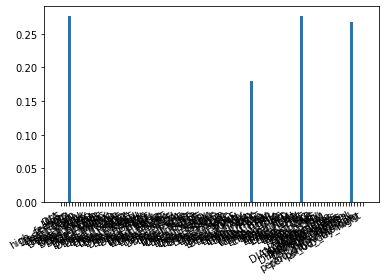

[0.         0.         0.         0.27693015 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17928578 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.27566838 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [14]:
fig, ax1 = plt.subplots()
feature_enc_headers = encoded_data_headers
#feature_enc_headers = feature_enc_headers.remove("delay_15")
ax1.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_, tick_label=list(train_X), width=1)
fig.autofmt_xdate()
plt.show()
print(clf.best_estimator_.feature_importances_)

importance_values = dict(zip(list(train_X), clf.best_estimator_.feature_importances_))
print(importance_values)


In [15]:
predictions = clf.predict(test_X)
accuracy_score(test_y, predictions)

0.8123350601114261

['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day', 'MES', 'high_season', 'fechats', 'delay_15']
['MES', 'high_season', 'fechats', 'delay_15', 'Des-I_CYYZ', 'Des-I_EGLL', 'Des-I_EGYP', 'Des-I_KATL', 'Des-I_KDFW', 'Des-I_KIAH', 'Des-I_KJFK', 'Des-I_KLAX', 'Des-I_KMCO', 'Des-I_KMIA', 'Des-I_LEMD', 'Des-I_LFPG', 'Des-I_LIRF', 'Des-I_MDPC', 'Des-I_MMMX', 'Des-I_MMUN', 'Des-I_MPTO', 'Des-I_NZAA', 'Des-I_SAAR', 'Des-I_SABE', 'Des-I_SACO', 'Des-I_SAEZ', 'Des-I_SAME', 'Des-I_SANT', 'Des-I_SANU', 'Des-I_SARI', 'Des-I_SAWH', 'Des-I_SAZN', 'Des-I_SAZS', 'Des-I_SBCT', 'Des-I_SBFI', 'Des-I_SBFL', 'Des-I_SBGL', 'Des-I_SBGR', 'Des-I_SCAR', 'Des-I_SCAT', 'Des-I_SCBA', 'Des-I_SCCF', 'Des-I_SCCI', 'Des-I_SCDA', 'Des-I_SCFA', 'Des-I_SCIE', 'Des-I_SCIP', 'Des-I_SCJO', 'Des-I_SCNT', 'Des-I_SCPQ', 'Des-I_SCQP', 'Des-I_SCSE', 'Des-I_SCTE', 'Des-I_SCVD', 'Des-I_SEGU', 'Des-I_SEQM', 'Des-I_SEQU', 'Des-I_SGAS', 'Des-I_SKBO', 'Des-I_SLCB', 'Des-I_SLLP', 'Des-I_SLVR', 'Des-I_SPJC', 'Des-I_SPSO', 'Des-I_SULS',

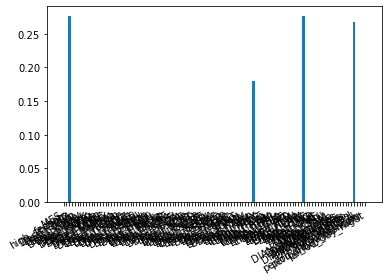

0.7515883100381194
[0.         0.         0.27693015 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.17928578 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.27566838 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [16]:
training_dataset = training_dataset[['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day', 'MES', 'high_season', 'fechats', 'delay_15']]

training_dataset_columns = list(training_dataset)
print(training_dataset_columns)

encoded_data = pd.get_dummies(training_dataset, columns = ['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day'])
encoded_data_headers = list(encoded_data)
print(encoded_data_headers)
train, test = train_test_split(encoded_data, test_size=.3, random_state=1999)
train_X = train.drop(['delay_15'], axis = 1)
train_y = train[['delay_15']].astype('int')
test_X = test.drop(['delay_15'], axis = 1)
test_y = test[['delay_15']].astype('int')
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X, train_y)
predictions = clf.predict(test_X)
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)
parameters = {'booster':['gbtree'], 'max_depth': [1],
     'eta':[0.2], 'objective': ['binary:logistic'],
     'num_parallel_tree': [40], 'n_jobs': [-1], 'tree_method': ['hist'],
     'n_estimators': [10], 'max_delta_step': [3], 'gamma': [0.]
              
    }
             

model = xgb.XGBClassifier()

clf = GridSearchCV(model, parameters, scoring='f1',  verbose=1000)
clf.fit(train_X, train_y)
fig, ax1 = plt.subplots()
feature_enc_headers = encoded_data_headers
#feature_enc_headers = feature_enc_headers.remove("delay_15")
ax1.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_, tick_label=list(train_X), width=1)
fig.autofmt_xdate()
plt.show()
print(accuracy_score(test_y, predictions))
print(clf.best_estimator_.feature_importances_)

importance_values = dict(zip(list(train_X), clf.best_estimator_.feature_importances_))
print(importance_values)
print(dict(sorted(importance_values.items(), reverse = True, key = lambda item: item[1])), '\n')

In [26]:
from sklearn import svm
clf = svm.SVC()
clf.fit(train_X, train_y)
predictions = clf.predict(test_X)
accuracy_score(test_y, predictions)


C:\Users\Felipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8123350601114261

(20462, 109)

In [23]:
from sklearn.neural_network import MLPClassifier
clf1 = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf1.fit(train_X, train_y)


C:\Users\Felipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='sgd')

In [24]:
predictions = clf1.predict(test_X)
accuracy_score(test_y, predictions)

0.8123350601114261

C:\Users\Felipe\AppData\Local\Temp/ipykernel_29900/3909437507.py:1: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  synthetic_features_csv = pd.read_csv("synthetic_features.csv")


['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day', 'DIA', 'MES', 'high_season', 'fechats', 'delay_15']
['DIA', 'MES', 'high_season', 'fechats', 'delay_15', 'Des-I_CYYZ', 'Des-I_EGLL', 'Des-I_EGYP', 'Des-I_KATL', 'Des-I_KDFW', 'Des-I_KIAH', 'Des-I_KJFK', 'Des-I_KLAX', 'Des-I_KMCO', 'Des-I_KMIA', 'Des-I_LEMD', 'Des-I_LFPG', 'Des-I_LIRF', 'Des-I_MDPC', 'Des-I_MMMX', 'Des-I_MMUN', 'Des-I_MPTO', 'Des-I_NZAA', 'Des-I_SAAR', 'Des-I_SABE', 'Des-I_SACO', 'Des-I_SAEZ', 'Des-I_SAME', 'Des-I_SANT', 'Des-I_SANU', 'Des-I_SARI', 'Des-I_SAWH', 'Des-I_SAZN', 'Des-I_SAZS', 'Des-I_SBCT', 'Des-I_SBFI', 'Des-I_SBFL', 'Des-I_SBGL', 'Des-I_SBGR', 'Des-I_SCAR', 'Des-I_SCAT', 'Des-I_SCBA', 'Des-I_SCCF', 'Des-I_SCCI', 'Des-I_SCDA', 'Des-I_SCFA', 'Des-I_SCIE', 'Des-I_SCIP', 'Des-I_SCJO', 'Des-I_SCNT', 'Des-I_SCPQ', 'Des-I_SCQP', 'Des-I_SCSE', 'Des-I_SCTE', 'Des-I_SCVD', 'Des-I_SEGU', 'Des-I_SEQM', 'Des-I_SEQU', 'Des-I_SGAS', 'Des-I_SKBO', 'Des-I_SLCB', 'Des-I_SLLP', 'Des-I_SLVR', 'Des-I_SPJC', 'Des-I_SPSO',

[CV 2/5; 4/6] END booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=2, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=exact;, score=0.000 total time=   6.2s
[CV 3/5; 4/6] START booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=2, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=exact
[CV 3/5; 4/6] END booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=2, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=exact;, score=0.000 total time=   6.1s
[CV 4/5; 4/6] START booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=2, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=exact
[CV 4/5; 4/6] END booster=gbtree, eta=0.2, gamma=0.0, max_delta_step=3, max_depth=2, n_estimators=10, n_jobs=-1, num_parallel_tree=40, objective=binary:logistic, tree_method=exact;, score=0.000 total time=   6.

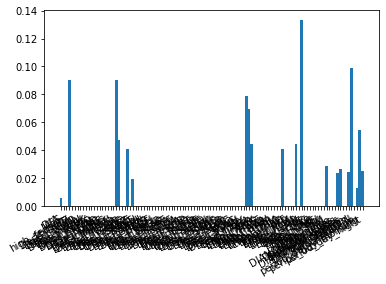

[0.00558234 0.         0.         0.09028988 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09035164 0.04734284 0.         0.
 0.04058842 0.         0.01954909 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.07859893 0.06982525 0.04431643 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04095075 0.         0.         0.
 0.         0.04464393 0.         0.1335897  0.         0.
 0.         0.         0.         0.         0.         0.
 0.02855605 0.         0.         0.         0.02393363 

In [39]:
synthetic_features_csv = pd.read_csv("synthetic_features.csv")

columns_names = list(synthetic_features_csv)

training_dataset = synthetic_features_csv.drop(['Fecha-O', 'Vlo-O', 'Des-O', 'Emp-O', 'min_diff', 'OPERA', 'Vlo-I'], axis = 1)
training_dataset = training_dataset.assign(fechats = lambda df: pd.to_datetime(
    df['Fecha-I'], format='%Y-%m-%d %H:%M:%S').astype(np.int64) // 10**9)
training_dataset = training_dataset.drop(['Fecha-I'], axis = 1)

training_dataset = training_dataset[['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day', 'DIA', 'MES', 'high_season', 'fechats', 'delay_15']]

training_dataset_columns = list(training_dataset)
print(training_dataset_columns)

encoded_data = pd.get_dummies(training_dataset, columns = ['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day'])
encoded_data_headers = list(encoded_data)
print(encoded_data_headers)
train, test = train_test_split(encoded_data, test_size=.3, random_state=1999)
train_X = train.drop(['delay_15'], axis = 1)
train_y = train[['delay_15']].astype('int')
test_X = test.drop(['delay_15'], axis = 1)
test_y = test[['delay_15']].astype('int')

from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)
parameters = {'booster':['gbtree'], 'max_depth': [1,2,3],
     'eta':[0.2], 'objective': ['binary:logistic'],
     'num_parallel_tree': [40], 'n_jobs': [-1], 'tree_method': ['hist', 'exact'],
     'n_estimators': [10], 'max_delta_step': [3], 'gamma': [0.]
              
    }
             

model = xgb.XGBClassifier()

clf = GridSearchCV(model, parameters, scoring='f1',  verbose=1000)
clf.fit(train_X, train_y)
predictions = clf.predict(test_X)
print(accuracy_score(test_y, predictions))

fig, ax1 = plt.subplots()
feature_enc_headers = encoded_data_headers
#feature_enc_headers = feature_enc_headers.remove("delay_15")
ax1.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_, tick_label=list(train_X), width=1)
fig.autofmt_xdate()
plt.show()
print(clf.best_estimator_.feature_importances_)

importance_values = dict(zip(list(train_X), clf.best_estimator_.feature_importances_))
print(importance_values)
print(dict(sorted(importance_values.items(), reverse = True, key = lambda item: item[1])), '\n')

In [41]:
predictions = clf.predict(test_X)
tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
score = accuracy_score(test_y, predictions)
report = classification_report(test_y, predictions)

print("Confusion Matrix")
print("TN: {}, FP: {}, FN: {}, TP: {}\n".format(tn, fp, fn, tp))
print("Score: {}".format(score))
print("Report: \n", report)

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462



In [42]:
prediction_prob = clf.predict_proba(test_X)

cases = []
for probability in np.linspace(0.5,1,500,endpoint=False):
    print("Probability {}".format(probability))
    prediction = [ 1 if i > probability else 0 for i in prediction_prob[:,1]]
    tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
    cases.append([tn, fp, fn, tp, probability, precision_recall_fscore_support(test_y, predictions, average='binary')])
    score = accuracy_score(test_y, predictions)
    report = classification_report(test_y, predictions)    
    print("Confusion Matrix")
    print("TN: {}, FP: {}, FN: {}, TP: {}\n".format(tn, fp, fn, tp))
    print("Score: {}".format(score))
    print("Report: \n", report)
    
    print("------------------------------------------------------------\n")

Probability 0.5
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.501
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probabil

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.518
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.519
Confus


Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.536
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.537
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.553
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.554
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.5700000000000001
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.59
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.591
Confusi

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.607
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.608
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.626
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.627
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.646
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.647
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.664
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.665
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.683
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.6839999999

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.7010000000000001
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.718
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.719
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.737
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.738
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.757
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.758
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.777
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.778
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.796
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.7969999999

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.8160000000000001
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.8360000000000001
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.854
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.855
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.872
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.873
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.892
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.893
Confus

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.91
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.911
Confusi

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.9279999999999999
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.946
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.9470000000

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.9650000000000001
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability

Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.983
Confusion Matrix
TN: 16609, FP: 13, FN: 3829, TP: 11

Score: 0.8122373179552341
Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16622
           1       0.46      0.00      0.01      3840

    accuracy                           0.81     20462
   macro avg       0.64      0.50      0.45     20462
weighted avg       0.75      0.81      0.73     20462

------------------------------------------------------------

Probability 0.984
Confus

In [58]:
print(prediction_prob[:,1])
print(test_y)
all_delayed = []
all_in_time = []
print(enumerate(test_y))
for idx, val in enumerate(test_y.to_numpy()):
    print(val)
    print(prediction_prob[:,1][idx])
    if val[0]:
        all_delayed.append(prediction_prob[:,1][idx])
    else:
        all_in_time.append(prediction_prob[:,1][idx])
        
print(len(all_delayed))
print(len(all_in_time))
test_y.head()

[0.3201419  0.24422844 0.29263407 ... 0.22680408 0.2530495  0.24347863]
       delay_15
38130         1
57893         0
33795         0
38952         0
65408         0
...         ...
50818         0
36882         1
16238         0
48355         0
38736         0

[20462 rows x 1 columns]
[1]
0.3201419
[0]
0.24422844
[0]
0.29263407
[0]
0.1680948
[0]
0.2366681
[0]
0.15026203
[0]
0.2064061
[0]
0.14415693
[1]
0.2478524
[0]
0.2460582
[0]
0.15367155
[1]
0.19827226
[1]
0.23601316
[1]
0.34451064
[0]
0.24422844
[0]
0.22680408
[0]
0.26243874
[0]
0.23258436
[1]
0.15026203
[0]
0.2427443
[0]
0.15945698
[0]
0.2804441
[0]
0.3706982
[0]
0.21339124
[0]
0.19477381
[0]
0.22680408
[1]
0.2618279
[1]
0.28776878
[0]
0.30319062
[0]
0.29263407
[1]
0.20802996
[0]
0.23601316
[0]
0.19093463
[1]
0.22680408
[0]
0.24347863
[1]
0.24424715
[1]
0.19898267
[0]
0.15304562
[0]
0.14050663
[0]
0.22680408
[0]
0.2646442
[0]
0.22680408
[0]
0.25251827
[1]
0.24422844
[0]
0.22135642
[0]
0.21493304
[0]
0.1649956
[0]
0.14415693
[0

0.25933668
[0]
0.15562488
[0]
0.15538633
[0]
0.22680408
[0]
0.21226029
[0]
0.25666642
[0]
0.14415693
[0]
0.15633865
[0]
0.15367155
[0]
0.2427443
[0]
0.14415693
[0]
0.16483407
[0]
0.15538633
[1]
0.2285741
[0]
0.2366681
[0]
0.15538633
[0]
0.2530495
[0]
0.15633865
[1]
0.28413817
[0]
0.23344211
[1]
0.22680408
[0]
0.15848927
[0]
0.24422844
[0]
0.15003023
[0]
0.222126
[0]
0.16849452
[0]
0.20134884
[0]
0.22680408
[1]
0.26243874
[0]
0.172493
[0]
0.24486533
[1]
0.21339124
[0]
0.15026203
[0]
0.19093463
[1]
0.25251827
[0]
0.3223935
[1]
0.22680408
[0]
0.24422844
[1]
0.23601316
[0]
0.49156237
[0]
0.22680408
[0]
0.23283269
[1]
0.25251827
[0]
0.24347863
[0]
0.22135642
[1]
0.2478524
[0]
0.2285741
[0]
0.1555403
[0]
0.15026203
[0]
0.1592137
[0]
0.14415693
[1]
0.45397174
[1]
0.22680408
[1]
0.15304562
[1]
0.15940106
[0]
0.18324775
[1]
0.22379805
[0]
0.22936139
[0]
0.19970721
[0]
0.24422844
[0]
0.2478524
[0]
0.14415693
[0]
0.23997551
[0]
0.2460582
[1]
0.35881498
[1]
0.28817752
[0]
0.171806
[1]
0.24347863
[

0.2427443
[0]
0.15633865
[0]
0.24422844
[0]
0.2427443
[1]
0.22680408
[0]
0.15026203
[0]
0.2774456
[0]
0.18753536
[1]
0.24347863
[0]
0.21226029
[0]
0.31129274
[0]
0.14050663
[0]
0.23344211
[0]
0.24538517
[0]
0.1555403
[0]
0.22680408
[0]
0.2064061
[0]
0.2064061
[0]
0.15562488
[0]
0.26232123
[0]
0.25251827
[0]
0.15304562
[1]
0.24347863
[0]
0.19898267
[0]
0.24347863
[0]
0.23997551
[1]
0.28817752
[1]
0.22680408
[0]
0.26930913
[0]
0.21226029
[0]
0.19621247
[1]
0.24486533
[0]
0.2618279
[0]
0.22042271
[0]
0.21339124
[0]
0.21339124
[0]
0.2605758
[1]
0.3726888
[0]
0.14934018
[0]
0.21493304
[1]
0.2605758
[0]
0.19392489
[0]
0.24347863
[0]
0.24538517
[0]
0.16010416
[1]
0.19392489
[1]
0.22680408
[1]
0.26728204
[0]
0.22680408
[0]
0.14415693
[1]
0.24486533
[0]
0.15913327
[0]
0.22379805
[0]
0.15904629
[0]
0.14415693
[0]
0.2064061
[0]
0.25647378
[0]
0.24486533
[0]
0.16665643
[0]
0.21339124
[0]
0.22680408
[0]
0.24486533
[0]
0.3201419
[0]
0.19741184
[0]
0.18992421
[0]
0.15026203
[0]
0.21226029
[0]
0.21339

[0]
0.1748902
[0]
0.22680408
[0]
0.15026203
[0]
0.19970721
[0]
0.22680408
[1]
0.22680408
[0]
0.23344211
[0]
0.25081596
[1]
0.18867968
[0]
0.24347863
[0]
0.19093463
[0]
0.22680408
[0]
0.24347863
[0]
0.21339124
[0]
0.19970721
[0]
0.24486533
[0]
0.21339124
[1]
0.28776878
[0]
0.2453927
[0]
0.24422844
[0]
0.24347863
[1]
0.25251827
[1]
0.22680408
[0]
0.22680408
[0]
0.2366681
[1]
0.23283269
[0]
0.24422844
[0]
0.23258436
[1]
0.15562488
[1]
0.26728204
[0]
0.15026203
[0]
0.22680408
[0]
0.28278774
[1]
0.25647378
[0]
0.23344211
[1]
0.22680408
[0]
0.21339124
[0]
0.1592137
[0]
0.22680408
[0]
0.25933668
[0]
0.19093463
[0]
0.2605758
[0]
0.22680408
[0]
0.16566083
[0]
0.24486533
[0]
0.24422844
[0]
0.14934018
[0]
0.22680408
[0]
0.19898267
[0]
0.23601316
[0]
0.22680408
[0]
0.1555403
[1]
0.22042271
[0]
0.14415693
[0]
0.18867968
[1]
0.23601316
[0]
0.14415693
[0]
0.14415693
[0]
0.2460582
[1]
0.20134884
[0]
0.21226029
[0]
0.15562488
[0]
0.23344211
[1]
0.46601245
[0]
0.15562488
[0]
0.1649956
[0]
0.19741184
[0]

[0]
0.22042271
[0]
0.15026203
[0]
0.16566083
[0]
0.24422844
[0]
0.2774456
[0]
0.22680408
[0]
0.15026203
[0]
0.14415693
[0]
0.25251827
[0]
0.2530495
[1]
0.22680408
[1]
0.15367155
[0]
0.23344211
[0]
0.26232123
[0]
0.22379805
[0]
0.24422844
[0]
0.22042271
[1]
0.2366681
[0]
0.1555403
[0]
0.14050663
[1]
0.15003023
[0]
0.196997
[0]
0.1748902
[0]
0.24347863
[0]
0.2366681
[0]
0.1555403
[0]
0.24486533
[0]
0.16566083
[0]
0.19093463
[0]
0.22680408
[1]
0.22680408
[0]
0.2460582
[1]
0.22936139
[0]
0.22680408
[0]
0.15026203
[1]
0.21226029
[0]
0.19093463
[0]
0.25251827
[0]
0.19970721
[0]
0.26140624
[0]
0.19741184
[0]
0.14934018
[1]
0.3706982
[1]
0.26728204
[1]
0.2605758
[1]
0.22680408
[0]
0.19970721
[0]
0.25447175
[0]
0.25381884
[1]
0.24424715
[0]
0.22680408
[0]
0.14415693
[0]
0.21339124
[0]
0.30701518
[0]
0.19970721
[0]
0.22680408
[0]
0.2478524
[0]
0.19741184
[0]
0.1555403
[0]
0.22379805
[0]
0.22680408
[0]
0.19093463
[1]
0.1748902
[1]
0.25081596
[0]
0.19741184
[0]
0.26930913
[0]
0.23258436
[1]
0.2593

0.49156237
[0]
0.25081596
[0]
0.22680408
[0]
0.29263407
[0]
0.23601316
[0]
0.23601316
[0]
0.24347863
[0]
0.22680408
[0]
0.22680408
[1]
0.15848927
[0]
0.23344211
[0]
0.16566083
[1]
0.24486533
[0]
0.25122985
[0]
0.21493304
[1]
0.3201419
[1]
0.25447175
[0]
0.22042271
[0]
0.15299153
[0]
0.22680408
[1]
0.22680408
[0]
0.22680408
[0]
0.22680408
[0]
0.14050663
[0]
0.21339124
[1]
0.25933668
[1]
0.22680408
[0]
0.2453927
[0]
0.22936139
[0]
0.15026203
[0]
0.24347863
[0]
0.15003023
[1]
0.22680408
[0]
0.19741184
[0]
0.15367155
[0]
0.19392489
[0]
0.30655685
[0]
0.24347863
[0]
0.15026203
[0]
0.2366681
[0]
0.31129274
[0]
0.15904629
[0]
0.2774456
[0]
0.14934018
[0]
0.22680408
[0]
0.23344211
[0]
0.22680408
[0]
0.17015456
[0]
0.19741184
[0]
0.22680408
[0]
0.25251827
[0]
0.38380262
[0]
0.2202288
[0]
0.14415693
[1]
0.24186316
[0]
0.19093463
[1]
0.25251827
[0]
0.15945698
[0]
0.24486533
[0]
0.22680408
[0]
0.22680408
[0]
0.24347863
[0]
0.26728204
[1]
0.25933668
[0]
0.25251827
[0]
0.15026203
[0]
0.26728204
[0]


0.14415693
[0]
0.25251827
[0]
0.22680408
[0]
0.2366681
[0]
0.22680408
[1]
0.19970721
[0]
0.24486533
[0]
0.21226029
[0]
0.19970721
[1]
0.2646442
[0]
0.22680408
[0]
0.22680408
[0]
0.22680408
[0]
0.19741184
[0]
0.16203618
[0]
0.17306568
[0]
0.2366681
[0]
0.23601316
[0]
0.24422844
[0]
0.15367155
[0]
0.24538517
[1]
0.24347863
[1]
0.24347863
[0]
0.15974039
[0]
0.25081596
[1]
0.19970721
[0]
0.29839414
[0]
0.14415693
[0]
0.15299153
[0]
0.16508424
[0]
0.23344211
[0]
0.19741184
[0]
0.14050663
[0]
0.19970721
[0]
0.19392489
[0]
0.3201419
[0]
0.28776878
[0]
0.29343256
[0]
0.19827226
[0]
0.23601316
[0]
0.22680408
[1]
0.22680408
[0]
0.1748902
[0]
0.14934018
[0]
0.15304562
[0]
0.19970721
[0]
0.22680408
[1]
0.2774456
[0]
0.14415693
[1]
0.25381884
[0]
0.19093463
[0]
0.1555403
[0]
0.14934018
[0]
0.2937581
[0]
0.22680408
[0]
0.22680408
[1]
0.17713268
[1]
0.24347863
[1]
0.2064061
[0]
0.25081596
[0]
0.25251827
[0]
0.22680408
[0]
0.24347863
[0]
0.17306568
[0]
0.16722085
[0]
0.16508424
[1]
0.22680408
[1]
0.22

0.15003023
[1]
0.19392489
[1]
0.22680408
[0]
0.23258436
[0]
0.22680408
[0]
0.23601316
[1]
0.15026203
[0]
0.2539882
[0]
0.14415693
[0]
0.1555403
[0]
0.25081596
[0]
0.14415693
[0]
0.14934018
[0]
0.25251827
[0]
0.3493315
[0]
0.16849452
[1]
0.20802996
[0]
0.14934018
[0]
0.20802996
[0]
0.33140635
[0]
0.25933668
[0]
0.2460582
[0]
0.25933668
[0]
0.25251827
[0]
0.26142466
[1]
0.33300316
[0]
0.22680408
[0]
0.15003023
[1]
0.3201419
[0]
0.22042271
[0]
0.21339124
[0]
0.22680408
[0]
0.24347863
[0]
0.24422844
[0]
0.2064061
[1]
0.15367155
[0]
0.23601316
[0]
0.14934018
[0]
0.15633865
[0]
0.22680408
[1]
0.3223935
[1]
0.25447175
[0]
0.22680408
[0]
0.24422844
[0]
0.23344211
[0]
0.25251827
[0]
0.15299153
[0]
0.19741184
[0]
0.19741184
[0]
0.21339124
[0]
0.14415693
[0]
0.19970721
[0]
0.15940106
[0]
0.2064061
[1]
0.25251827
[0]
0.16178972
[0]
0.1936538
[0]
0.23258436
[0]
0.23997551
[0]
0.15538633
[0]
0.25251827
[0]
0.24422844
[0]
0.14415693
[0]
0.23344211
[0]
0.14415693
[0]
0.23601316
[0]
0.21339124
[0]
0.17

[0]
0.22680408
[0]
0.14415693
[1]
0.26728204
[0]
0.23344211
[0]
0.22680408
[0]
0.22680408
[0]
0.2478524
[0]
0.19970721
[0]
0.2804441
[0]
0.21339124
[0]
0.17015456
[0]
0.22680408
[0]
0.222126
[1]
0.25666642
[0]
0.2478524
[0]
0.17986926
[0]
0.26232123
[0]
0.26728204
[0]
0.2366681
[0]
0.24422844
[0]
0.24347863
[0]
0.2064061
[0]
0.25081596
[0]
0.33140635
[0]
0.15026203
[0]
0.24186316
[0]
0.24347863
[0]
0.22680408
[0]
0.14934018
[0]
0.20755485
[0]
0.22680408
[0]
0.36288583
[1]
0.26232123
[0]
0.14050663
[0]
0.45397174
[0]
0.22680408
[0]
0.22680408
[1]
0.25122985
[1]
0.15913327
[0]
0.15945698
[0]
0.22680408
[0]
0.22680408
[0]
0.33251536
[0]
0.19970721
[0]
0.24347863
[0]
0.22680408
[0]
0.15304562
[0]
0.22680408
[0]
0.25753647
[0]
0.24347863
[0]
0.15304562
[0]
0.34267342
[0]
0.2804441
[0]
0.2478524
[0]
0.25251827
[1]
0.22680408
[0]
0.30336252
[0]
0.21339124
[0]
0.23283269
[0]
0.24424715
[0]
0.24347863
[0]
0.22680408
[0]
0.15538633
[0]
0.26728204
[0]
0.24945396
[0]
0.2478524
[0]
0.2646442
[0]
0.

0.22680408
[0]
0.14415693
[0]
0.14050663
[0]
0.15367155
[0]
0.22680408
[0]
0.19970721
[0]
0.14415693
[0]
0.2366681
[0]
0.24422844
[0]
0.22680408
[0]
0.24945396
[0]
0.222126
[0]
0.25251827
[0]
0.22680408
[1]
0.22680408
[0]
0.2064061
[0]
0.22680408
[0]
0.22680408
[0]
0.19093463
[0]
0.19970721
[0]
0.15026203
[0]
0.21339124
[1]
0.26728204
[0]
0.14415693
[0]
0.19093463
[0]
0.23344211
[1]
0.45397174
[0]
0.2774456
[0]
0.2064061
[0]
0.15003023
[0]
0.23997551
[0]
0.25933668
[0]
0.15026203
[0]
0.2366681
[0]
0.22680408
[0]
0.2478524
[0]
0.14415693
[0]
0.19970721
[0]
0.25666642
[1]
0.3223935
[1]
0.26728204
[0]
0.14415693
[0]
0.24422844
[1]
0.22680408
[0]
0.1748902
[0]
0.15940106
[0]
0.19093463
[0]
0.15633865
[0]
0.15003023
[0]
0.21339124
[0]
0.22680408
[0]
0.19093463
[1]
0.2366681
[0]
0.22680408
[0]
0.14415693
[0]
0.22680408
[0]
0.22680408
[0]
0.15299153
[1]
0.19827226
[0]
0.23997551
[1]
0.45397174
[0]
0.19093463
[0]
0.14415693
[0]
0.21226029
[0]
0.1748902
[1]
0.23344211
[0]
0.22680408
[0]
0.24347

0.16187704
[0]
0.2209617
[0]
0.15633865
[0]
0.14415693
[0]
0.24347863
[0]
0.14934018
[0]
0.16104485
[0]
0.14415693
[0]
0.22680408
[0]
0.22680408
[0]
0.16665643
[0]
0.14415693
[0]
0.14415693
[1]
0.25666642
[1]
0.14415693
[0]
0.29263407
[0]
0.15304562
[1]
0.23344211
[0]
0.22680408
[0]
0.24422844
[0]
0.16248488
[0]
0.32024282
[1]
0.22680408
[0]
0.15026203
[0]
0.23258436
[0]
0.2618279
[0]
0.16508424
[0]
0.22680408
[0]
0.16203618
[0]
0.22680408
[0]
0.2285741
[0]
0.1555403
[0]
0.25251827
[1]
0.23997551
[0]
0.24347863
[0]
0.2064061
[0]
0.21339124
[1]
0.15304562
[0]
0.25251827
[1]
0.23601316
[1]
0.22680408
[0]
0.2530495
[0]
0.15562488
[1]
0.24347863
[1]
0.23344211
[1]
0.33300316
[0]
0.16297823
[0]
0.25251827
[0]
0.25933668
[1]
0.15562488
[0]
0.1555403
[0]
0.22042271
[0]
0.15304562
[1]
0.19190565
[1]
0.26728204
[1]
0.22680408
[0]
0.14050663
[0]
0.26232123
[1]
0.23997551
[0]
0.48515716
[1]
0.25251827
[0]
0.23344211
[0]
0.14415693
[0]
0.24347863
[0]
0.2453927
[0]
0.2427443
[1]
0.22680408
[0]
0.14

[0]
0.25647378
[1]
0.45397174
[0]
0.15230638
[1]
0.28776878
[0]
0.2937581
[0]
0.21339124
[0]
0.21339124
[0]
0.21339124
[0]
0.22680408
[0]
0.2478524
[0]
0.31129274
[0]
0.22680408
[0]
0.25081596
[1]
0.23344211
[0]
0.28413817
[0]
0.22042271
[0]
0.22680408
[0]
0.14415693
[0]
0.2366681
[0]
0.16203618
[1]
0.34451064
[0]
0.15304562
[0]
0.24347863
[1]
0.3201419
[0]
0.1555403
[0]
0.14709276
[0]
0.14963645
[0]
0.14415693
[0]
0.27248654
[0]
0.2478524
[1]
0.2478524
[0]
0.29468492
[1]
0.28776878
[0]
0.26728204
[1]
0.25251827
[0]
0.24486533
[0]
0.1555403
[1]
0.26232123
[0]
0.19741184
[0]
0.23344211
[0]
0.25251827
[0]
0.15026203
[0]
0.2056635
[0]
0.26142466
[0]
0.22135642
[0]
0.24486533
[0]
0.15562488
[0]
0.2366681
[0]
0.22680408
[0]
0.21339124
[0]
0.14050663
[0]
0.14415693
[0]
0.25251827
[0]
0.1739011
[0]
0.15299153
[0]
0.1748902
[0]
0.1450929
[0]
0.14934018
[0]
0.19741184
[0]
0.23601316
[0]
0.15003023
[1]
0.2064061
[0]
0.22042271
[0]
0.23344211
[0]
0.24486533
[0]
0.25251827
[0]
0.14415693
[0]
0.233

0.15367155
[0]
0.21339124
[0]
0.2056635
[1]
0.22042271
[0]
0.15848927
[0]
0.24422844
[0]
0.24486533
[0]
0.24347863
[0]
0.14934018
[0]
0.24538517
[0]
0.28413817
[0]
0.1555403
[0]
0.14415693
[0]
0.2538791
[1]
0.23344211
[0]
0.19970721
[0]
0.24422844
[1]
0.15562488
[0]
0.15003023
[0]
0.15913327
[0]
0.2478524
[0]
0.24347863
[0]
0.14415693
[0]
0.24486533
[0]
0.25251827
[0]
0.30655685
[0]
0.15367155
[1]
0.3201419
[0]
0.14415693
[0]
0.14415693
[1]
0.15562488
[0]
0.38380262
[0]
0.19898267
[0]
0.22680408
[0]
0.19970721
[0]
0.22680408
[0]
0.14415693
[1]
0.23344211
[1]
0.14415693
[0]
0.24486533
[0]
0.25647378
[0]
0.15367155
[0]
0.25381884
[0]
0.21226029
[0]
0.22680408
[0]
0.24347863
[0]
0.28648978
[0]
0.22680408
[1]
0.2478524
[0]
0.14825156
[0]
0.25251827
[0]
0.25251827
[0]
0.15299153
[0]
0.19970721
[0]
0.28646392
[1]
0.2774456
[0]
0.25251827
[1]
0.25251827
[0]
0.17713268
[1]
0.23344211
[0]
0.16178972
[0]
0.24347863
[0]
0.14050663
[0]
0.14415693
[0]
0.25251827
[0]
0.14415693
[0]
0.31129274
[1]
0.

0.2774456
[1]
0.26099953
[0]
0.14415693
[0]
0.24486533
[0]
0.2804441
[0]
0.22680408
[0]
0.26243874
[0]
0.172493
[0]
0.17306568
[0]
0.21226029
[0]
0.28413817
[0]
0.2366681
[0]
0.26142466
[0]
0.2605758
[0]
0.14415693
[1]
0.25251827
[0]
0.16566083
[0]
0.16203618
[0]
0.25251827
[0]
0.17163919
[0]
0.19741184
[0]
0.23997551
[0]
0.22680408
[1]
0.1592137
[0]
0.22680408
[0]
0.21339124
[0]
0.22680408
[0]
0.19970721
[0]
0.24486533
[0]
0.24347863
[1]
0.34708676
[0]
0.15562488
[0]
0.24347863
[1]
0.26728204
[0]
0.2366681
[0]
0.21339124
[1]
0.25251827
[0]
0.15367155
[0]
0.22680408
[0]
0.25081596
[1]
0.25251827
[0]
0.22680408
[0]
0.2738562
[0]
0.15367155
[0]
0.15913327
[0]
0.22680408
[0]
0.172493
[0]
0.24347863
[0]
0.14415693
[0]
0.26872382
[0]
0.15026203
[0]
0.24422844
[0]
0.22680408
[0]
0.16232167
[0]
0.25122985
[0]
0.21493304
[0]
0.25251827
[1]
0.2804441
[0]
0.2774456
[0]
0.22680408
[0]
0.24486533
[0]
0.22680408
[0]
0.14934018
[0]
0.24422844
[0]
0.18753536
[0]
0.25666642
[0]
0.24347863
[0]
0.159456

[1]
0.22680408
[0]
0.22680408
[0]
0.14415693
[0]
0.16665643
[0]
0.24347863
[0]
0.15633865
[0]
0.23997551
[0]
0.15304562
[0]
0.14934018
[0]
0.3201419
[0]
0.24486533
[0]
0.15026203
[1]
0.24347863
[0]
0.15913327
[1]
0.22680408
[0]
0.17306568
[0]
0.17306568
[0]
0.21339124
[0]
0.14415693
[0]
0.22936139
[0]
0.24422844
[1]
0.22680408
[1]
0.24347863
[0]
0.18753536
[1]
0.2427443
[0]
0.22680408
[0]
0.20802996
[0]
0.15026203
[0]
0.25251827
[0]
0.17384297
[0]
0.25447175
[0]
0.25933668
[0]
0.19741184
[0]
0.22680408
[1]
0.30655685
[1]
0.23601316
[1]
0.22680408
[0]
0.15633865
[0]
0.29263407
[0]
0.3201419
[0]
0.14050663
[0]
0.17608024
[1]
0.19093463
[0]
0.22680408
[1]
0.26243874
[0]
0.38380262
[0]
0.15026203
[0]
0.14415693
[0]
0.15562488
[0]
0.15367155
[0]
0.14415693
[0]
0.22680408
[0]
0.15562488
[0]
0.1555403
[1]
0.20755485
[0]
0.25933668
[1]
0.1555403
[1]
0.23344211
[1]
0.25081596
[0]
0.15003023
[1]
0.22680408
[0]
0.14934018
[0]
0.15913327
[0]
0.2064061
[0]
0.25251827
[0]
0.17306568
[0]
0.19970721
[

0.25381884
[0]
0.2064061
[1]
0.31129274
[0]
0.23344211
[1]
0.24486533
[0]
0.2064061
[0]
0.16849452
[0]
0.23203707
[0]
0.28708392
[0]
0.23344211
[0]
0.2478524
[0]
0.14934018
[0]
0.17384297
[1]
0.2202288
[0]
0.15945698
[1]
0.25251827
[0]
0.24347863
[0]
0.19190565
[1]
0.2064061
[0]
0.2209617
[0]
0.34944618
[0]
0.22680408
[0]
0.14415693
[0]
0.22379805
[0]
0.22042271
[0]
0.2366681
[0]
0.15367155
[0]
0.14415693
[0]
0.24347863
[0]
0.19093463
[0]
0.19970721
[0]
0.19093463
[0]
0.15304562
[0]
0.28776878
[0]
0.23344211
[0]
0.25251827
[0]
0.15538633
[0]
0.14934018
[0]
0.22680408
[1]
0.3120079
[0]
0.19093463
[0]
0.14415693
[0]
0.19741184
[0]
0.25251827
[0]
0.15945698
[0]
0.31129274
[1]
0.26872382
[0]
0.23601316
[0]
0.23344211
[0]
0.24347863
[0]
0.16849452
[0]
0.21339124
[0]
0.2366681
[0]
0.19392489
[1]
0.3334095
[1]
0.25381884
[0]
0.2064061
[0]
0.23344211
[0]
0.21339124
[0]
0.21339124
[0]
0.222126
[0]
0.22680408
[0]
0.14415693
[0]
0.2366681
[1]
0.22680408
[0]
0.19970721
[0]
0.15633865
[0]
0.2268040

0.22042271
[0]
0.21339124
[0]
0.23344211
[0]
0.22680408
[0]
0.15913327
[0]
0.171806
[0]
0.21226029
[0]
0.24538517
[1]
0.28776878
[0]
0.22680408
[0]
0.23997551
[0]
0.2530495
[0]
0.19741184
[0]
0.15848927
[0]
0.24347863
[0]
0.20493533
[0]
0.19970721
[0]
0.25081596
[0]
0.22680408
[0]
0.24347863
[0]
0.24945396
[0]
0.22680408
[1]
0.25251827
[1]
0.22680408
[0]
0.22379805
[0]
0.25753647
[0]
0.19898267
[0]
0.14934018
[0]
0.4147228
[0]
0.16566083
[0]
0.30319062
[0]
0.14449859
[0]
0.24347863
[1]
0.222126
[0]
0.24422844
[0]
0.23344211
[0]
0.23601316
[1]
0.1555403
[0]
0.22680408
[0]
0.14415693
[0]
0.14415693
[0]
0.15230638
[0]
0.196997
[0]
0.22042271
[0]
0.3493315
[0]
0.2366681
[0]
0.19477381
[1]
0.23283269
[0]
0.22680408
[0]
0.21339124
[0]
0.19898267
[0]
0.15633865
[0]
0.23344211
[0]
0.2478524
[0]
0.22680408
[1]
0.16187704
[0]
0.24486533
[0]
0.21226029
[0]
0.14415693
[0]
0.25251827
[0]
0.24347863
[0]
0.25251827
[0]
0.2366681
[0]
0.2453927
[0]
0.24424715
[0]
0.19741184
[1]
0.18753536
[0]
0.2320370

[0]
0.16508424
[0]
0.15945698
[0]
0.22680408
[0]
0.22379805
[0]
0.19093463
[0]
0.22680408
[0]
0.22680408
[0]
0.24424715
[0]
0.22680408
[0]
0.18753536
[0]
0.16010416
[0]
0.14050663
[0]
0.25251827
[0]
0.21493304
[0]
0.23283269
[1]
0.25666642
[0]
0.24347863
[0]
0.17306568
[1]
0.23601316
[0]
0.24486533
[0]
0.25251827
[0]
0.2538791
[1]
0.196997
[0]
0.25251827
[0]
0.16203618
[0]
0.14050663
[0]
0.21226029
[0]
0.23344211
[0]
0.14415693
[1]
0.21339124
[0]
0.15026203
[1]
0.19970721
[0]
0.22042271
[0]
0.16010416
[0]
0.22680408
[0]
0.22680408
[0]
0.21339124
[0]
0.15026203
[1]
0.15003023
[0]
0.2308712
[0]
0.2064061
[0]
0.14934018
[1]
0.31129274
[1]
0.23344211
[0]
0.14415693
[0]
0.22680408
[0]
0.1555403
[0]
0.14415693
[0]
0.22680408
[0]
0.22680408
[0]
0.19741184
[0]
0.26657298
[0]
0.15304562
[0]
0.2209617
[0]
0.19190565
[0]
0.23601316
[0]
0.28776878
[1]
0.22680408
[0]
0.25933668
[0]
0.22042271
[0]
0.16566083
[0]
0.25251827
[0]
0.14934018
[0]
0.14415693
[0]
0.24422844
[0]
0.33140635
[0]
0.22680408
[0

0.23601316
[1]
0.45397174
[1]
0.22379805
[0]
0.1555403
[0]
0.32565844
[0]
0.15538633
[0]
0.15633865
[0]
0.22680408
[0]
0.19970721
[0]
0.22680408
[1]
0.19605754
[0]
0.21339124
[1]
0.21444644
[1]
0.24347863
[0]
0.2064061
[0]
0.22680408
[0]
0.16010416
[0]
0.19741184
[0]
0.19392489
[0]
0.14415693
[0]
0.25666642
[0]
0.22379805
[0]
0.172493
[0]
0.22680408
[0]
0.22680408
[0]
0.22680408
[0]
0.25251827
[0]
0.23344211
[0]
0.22042271
[0]
0.24347863
[0]
0.25251827
[1]
0.22680408
[0]
0.23344211
[0]
0.14415693
[1]
0.28413817
[0]
0.15026203
[0]
0.28886878
[0]
0.23997551
[1]
0.18753536
[0]
0.21226029
[0]
0.24347863
[0]
0.22680408
[0]
0.24422844
[0]
0.26232123
[0]
0.2064061
[0]
0.2366681
[1]
0.22680408
[0]
0.15230638
[0]
0.15304562
[1]
0.42109647
[0]
0.22680408
[0]
0.23203707
[0]
0.23997551
[0]
0.19741184
[0]
0.2366681
[1]
0.22680408
[0]
0.24422844
[0]
0.25647378
[1]
0.15538633
[0]
0.14934018
[1]
0.45397174
[0]
0.23601316
[0]
0.15848927
[0]
0.14934018
[0]
0.2056635
[0]
0.23601316
[0]
0.22680408
[0]
0.2

,delay_15
38130,1
57893,0
33795,0
38952,0
65408,0


C:\Users\Felipe\AppData\Local\Temp/ipykernel_29900/1876876053.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_delayed, hist=True, label='Signal')


<Axes: ylabel='Density'>

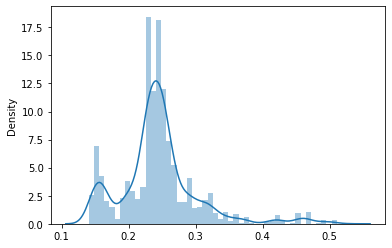

In [57]:
sns.distplot(all_delayed, hist=True, label='Signal')

In [53]:
print(prediction_prob[:,1])
sorted()

[0.3201419  0.24422844 0.29263407 ... 0.22680408 0.2530495  0.24347863]


C:\Users\Felipe\AppData\Local\Temp/ipykernel_29900/3037497608.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_in_time, hist=True, label='Signal')


<Axes: ylabel='Density'>

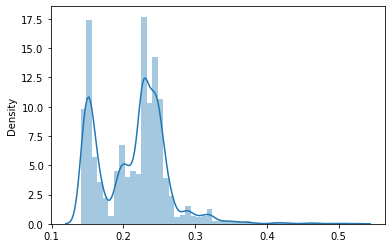

In [59]:
sns.distplot(all_in_time, hist=True, label='Signal')